In [1]:
options(warn = -1)
options(scipen = 100)
library(nnet)
library(party)
library(randomForest)
library(e1071)
library(caret)
library(dplyr)
library(Metrics)

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin


Attaching package: 'dplyr'

The following object is masked from 'package:randomForest':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, 

In [30]:
# 정확도 (결정계수)
rsquare <- function(pred, y) {
    return (1- (sum((y-pred)^2) / sum((y-mean(y))^2)))
}

# 인공 신경망
f.nnet <- function(data.tr, x, y) {
    model.nnet <- nnet(cluster ~ ., data=data.tr, size = 10) 
    pred <- predict(model.nnet, x, type="class")
    return (mean(pred == y))
}

# 의사 결정 나무
f.ctree <- function(data.tr, x, y) {
    model.ctree <- ctree(cluster ~ ., data=data.tr)
    pred <- predict(model.ctree, x)
    return (mean(pred == y))
}

# RandomForest
f.randomForest <- function(data.tr, x, y) {
    model.rf <- randomForest(cluster ~ ., data=data.tr, ntree=100)
    pred <- predict(model.rf, x)
    return (mean(pred == y))
}


# SVM
f.svm <- function(data.tr, x, y) {
    model.svm <- svm(cluster ~., data=data.tr)
    pred <- predict(model.svm, x)
    return (mean(pred == y))
}

# 다항 로지스틱 회귀분석
f.multinom <- function(data.tr, x, y) {
    model.multinom <- multinom(cluster ~ ., data=data.tr)
    pred <- predict(model.multinom, x)
    return (mean(pred == y))
}


In [3]:
data <- read.csv("./MLData.csv", fileEncoding = "utf-8")

In [4]:
mainData <- read.csv("./mainData.csv", fileEncoding = "utf-8")

In [5]:
mainData

영화명,누적매출액,누적관객수,스크린수,상영횟수,개봉일,배급사,등급,장르,감독,...,스크린점유율,배우누적점수,배우점수,감독점수,장르_관객점수부여,휴일,X12세이상관람가,X15세이상관람가,전체관람가,청소년관람불가
7급 공무원,26380710000,4039891,475,90779,2009-04-22,롯데쇼핑㈜롯데엔터테인먼트,12세이상관람가,"코미디,액션,드라마,범죄",신태라,...,23.79760,6.50000,4.000000,3.000000,10,9,TRUE,FALSE,FALSE,FALSE
82년생 김지영,30298542310,3678156,1486,145441,2019-10-23,롯데컬처웍스(주)롯데엔터테인먼트,12세이상관람가,드라마,김도영,...,48.26242,14.75000,8.250000,2.000000,10,8,TRUE,FALSE,FALSE,FALSE
감기,21774884000,3117859,806,55046,2013-08-14,아이러브시네마,15세이상관람가,"드라마,어드벤처,액션",김성수,...,36.90476,10.50000,4.000000,2.333333,10,8,FALSE,TRUE,FALSE,FALSE
강철중: 공공의 적 1-1,28638460100,4313101,707,74157,2008-06-19,"CJ ENM,(주)시네마서비스",15세이상관람가,"드라마,액션",강우석,...,35.27944,10.63492,6.777778,3.571429,10,9,FALSE,TRUE,FALSE,FALSE
거북이 달린다,20618276000,3024666,432,69946,2009-06-11,(주)쇼박스,15세이상관람가,"드라마,액션,범죄",이연우,...,21.64329,17.66667,7.666667,3.500000,10,9,FALSE,TRUE,FALSE,FALSE
건축학개론,30223590400,4111237,593,106069,2012-03-22,롯데쇼핑㈜롯데엔터테인먼트,12세이상관람가,"멜로/로맨스,드라마",이용주,...,28.49592,16.75000,6.500000,3.500000,20,10,TRUE,FALSE,FALSE,FALSE
공공의 적 2,20091127000,3134421,299,40642,2005-01-27,(주)시네마서비스,15세관람가,드라마,강우석,...,18.14320,13.27778,6.777778,3.571429,10,12,FALSE,TRUE,FALSE,FALSE
국가부도의 날,30893315837,3755233,1180,101077,2018-11-28,CJ ENM,12세이상관람가,드라마,최국희,...,40.17705,36.41667,11.750000,1.500000,10,9,TRUE,FALSE,FALSE,FALSE
귀향,27249801990,3587182,876,90288,2016-02-24,(주)와우픽쳐스,15세이상관람가,드라마,조정래,...,34.01942,44.00000,4.000000,4.000000,10,9,FALSE,TRUE,FALSE,FALSE
그것만이 내 세상,27456797382,3420172,956,95437,2018-01-17,CJ ENM,12세이상관람가,"코미디,드라마",최성현,...,32.55022,15.62500,11.375000,4.000000,10,9,TRUE,FALSE,FALSE,FALSE


In [6]:
set_one <- subset(data, cluster == 1)
set_two <- subset(data, cluster == 2)
set_three <- subset(data, cluster == 3)

In [7]:
data

cluster,감독_배우시너지,스크린점유율,감독점수,장르_관객점수부여,휴일,X12세이상관람가,X15세이상관람가,전체관람가,청소년관람불가,배우점수,누적관객수
1,3,23.79760,3.000000,10,9,TRUE,FALSE,FALSE,FALSE,4.000000,4039891
1,8,48.26242,2.000000,10,8,TRUE,FALSE,FALSE,FALSE,8.250000,3678156
1,0,36.90476,2.333333,10,8,FALSE,TRUE,FALSE,FALSE,4.000000,3117859
1,3,35.27944,3.571429,10,9,FALSE,TRUE,FALSE,FALSE,6.777778,4313101
1,0,21.64329,3.500000,10,9,FALSE,TRUE,FALSE,FALSE,7.666667,3024666
1,6,28.49592,3.500000,20,10,TRUE,FALSE,FALSE,FALSE,6.500000,4111237
1,1,18.14320,3.571429,10,12,FALSE,TRUE,FALSE,FALSE,6.777778,3134421
1,5,40.17705,1.500000,10,9,TRUE,FALSE,FALSE,FALSE,11.750000,3755233
1,7,34.01942,4.000000,10,9,FALSE,TRUE,FALSE,FALSE,4.000000,3587182
1,4,32.55022,4.000000,10,9,TRUE,FALSE,FALSE,FALSE,11.375000,3420172


In [8]:
result <- rep(0,5)
temp <- rep(0,5)
n <- 55
for (i in 1:n) {
    samp <- sample(1:43, 30)

    # 학습용 데이터 셋
    data.tr <- subset(set_one[samp,], select = c(누적관객수, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 검증용 데이터셋
    data.test <- subset(set_one[-samp,], select = c(누적관객수, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 문제 및 정답 만들기
    x <- subset(data.test, select = -누적관객수)
    y <- data.test$누적관객수
    result[1] <- result[1] + f.nnet(data.tr, x, y)
    result[2] <- result[2] + f.ctree(data.tr, x, y)
    result[3] <- result[3] + f.randomForest(data.tr, x, y)
    result[4] <- result[4] + f.svm(data.tr, x, y)
    result[5] <- result[5] + f.multinom(data.tr, x, y)
    
    temp[1] <- temp[1] + f.nnet(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[2] <- temp[2] + f.ctree(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[3] <- temp[3] + f.randomForest(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[4] <- temp[4] + f.svm(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[5] <- temp[5] + f.multinom(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
}
result <- result / n
temp <- temp / n


# weights:  71
initial  value 384277603141375.062500 
final  value 384277473643546.000000 
converged
# weights:  210 (174 variable)
initial  value 102.035921 
iter  10 value 57.533178
iter  20 value 39.537129
iter  30 value 29.147413
iter  40 value 8.156635
iter  50 value 0.052691
iter  60 value 0.000808
final  value 0.000071 
converged
# weights:  71
initial  value 384277518738216.687500 
final  value 384277473643546.000000 
converged
# weights:  210 (174 variable)
initial  value 102.035921 
iter  10 value 57.533178
iter  20 value 39.537129
iter  30 value 29.147413
iter  40 value 8.156635
iter  50 value 0.052691
iter  60 value 0.000808
final  value 0.000071 
converged
# weights:  71
initial  value 380150198914037.437500 
final  value 380150112775334.000000 
converged
# weights:  210 (174 variable)
initial  value 102.035921 
iter  10 value 67.526855
iter  20 value 47.943445
iter  30 value 35.826348
iter  40 value 17.771893
iter  50 value 0.917817
iter  60 value 0.004883
iter  70 value 

initial  value 102.035921 
iter  10 value 49.063000
iter  20 value 39.191149
iter  30 value 27.603922
iter  40 value 6.604669
iter  50 value 0.022705
iter  60 value 0.000715
final  value 0.000067 
converged
# weights:  71
initial  value 375967837625033.000000 
final  value 375967680311438.000000 
converged
# weights:  210 (174 variable)
initial  value 102.035921 
iter  10 value 54.275046
iter  20 value 41.952447
iter  30 value 33.882117
iter  40 value 16.304245
iter  50 value 0.240219
iter  60 value 0.005176
final  value 0.000055 
converged
# weights:  71
initial  value 375967746168757.875000 
final  value 375967680311438.000000 
converged
# weights:  210 (174 variable)
initial  value 102.035921 
iter  10 value 54.275046
iter  20 value 41.952447
iter  30 value 33.882117
iter  40 value 16.304245
iter  50 value 0.240219
iter  60 value 0.005176
final  value 0.000055 
converged
# weights:  71
initial  value 396520023823463.812500 
final  value 396519885669199.000000 
converged
# weights:  

initial  value 102.035921 
iter  10 value 56.230830
iter  20 value 43.038163
iter  30 value 34.265925
iter  40 value 12.667988
iter  50 value 0.158525
iter  60 value 0.000638
final  value 0.000048 
converged
# weights:  71
initial  value 394582111702903.500000 
final  value 394581927264200.000000 
converged
# weights:  210 (174 variable)
initial  value 102.035921 
iter  10 value 53.820889
iter  20 value 41.479019
iter  30 value 31.632441
iter  40 value 6.876205
iter  50 value 0.038671
iter  60 value 0.000150
final  value 0.000079 
converged
# weights:  71
initial  value 394582056765709.687500 
final  value 394581927264200.000000 
converged
# weights:  210 (174 variable)
initial  value 102.035921 
iter  10 value 53.820889
iter  20 value 41.479019
iter  30 value 31.632441
iter  40 value 6.876205
iter  50 value 0.038671
iter  60 value 0.000150
final  value 0.000079 
converged
# weights:  71
initial  value 400079726993584.625000 
final  value 400079694807896.000000 
converged
# weights:  2

initial  value 397170204771127.562500 
final  value 397170062307145.000000 
converged
# weights:  210 (174 variable)
initial  value 102.035921 
iter  10 value 57.790700
iter  20 value 43.875838
iter  30 value 35.379997
iter  40 value 14.909646
iter  50 value 0.214453
iter  60 value 0.000563
final  value 0.000051 
converged
# weights:  71
initial  value 381773872615843.312500 
final  value 381773726586801.000000 
converged
# weights:  210 (174 variable)
initial  value 102.035921 
iter  10 value 58.709865
iter  20 value 44.245159
iter  30 value 34.231662
iter  40 value 9.377981
iter  50 value 0.153498
iter  60 value 0.000744
final  value 0.000070 
converged
# weights:  71
initial  value 381773823577444.937500 
final  value 381773726586801.000000 
converged
# weights:  210 (174 variable)
initial  value 102.035921 
iter  10 value 58.709865
iter  20 value 44.245159
iter  30 value 34.231662
iter  40 value 9.377981
iter  50 value 0.153498
iter  60 value 0.000744
final  value 0.000070 
converg

initial  value 390511076628481.812500 
final  value 390511025952661.000000 
converged
# weights:  210 (174 variable)
initial  value 102.035921 
iter  10 value 59.279786
iter  20 value 47.048342
iter  30 value 34.551223
iter  40 value 14.941960
iter  50 value 0.359919
iter  60 value 0.008926
iter  70 value 0.000117
iter  70 value 0.000095
iter  70 value 0.000090
final  value 0.000090 
converged
# weights:  71
initial  value 393710277316089.875000 
final  value 393710138556244.000000 
converged
# weights:  210 (174 variable)
initial  value 102.035921 
iter  10 value 55.926876
iter  20 value 41.026349
iter  30 value 32.028382
iter  40 value 11.235769
iter  50 value 0.146445
iter  60 value 0.000342
final  value 0.000049 
converged
# weights:  71
initial  value 393710199768214.687500 
final  value 393710138556244.000000 
converged
# weights:  210 (174 variable)
initial  value 102.035921 
iter  10 value 55.926876
iter  20 value 41.026349
iter  30 value 32.028382
iter  40 value 11.235769
iter

In [9]:
res_all <- rbind(t(as.data.frame(temp)),
t(as.data.frame(result)))
colnames(res_all) <- c("인공신경망", "의사결정나무", "randomForest", "SVM", "다항로지스틱회귀분석")
rownames(res_all) <- c("트레이닝", "테스트")
res_all

,인공신경망,의사결정나무,randomForest,SVM,다항로지스틱회귀분석
트레이닝,-83.54454,0.5051043,0.7104800,0.57878627,NA
테스트,-93.13953,0.4126043,0.1329681,0.08644441,NA


In [10]:
result <- rep(0,5)
temp <- rep(0,5)
n <- 55
for (i in 1:n) {
    samp <- createDataPartition(set_two$누적관객수, p = 0.7, list = F)

    # 학습용 데이터 셋
    data.tr <- subset(set_two[samp,], select = c(누적관객수, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 검증용 데이터셋
    data.test <- subset(set_two[-samp,], select = c(누적관객수, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 문제 및 정답 만들기
    x <- subset(data.test, select = -누적관객수)
    y <- data.test$누적관객수
    result[1] <- result[1] + f.nnet(data.tr, x, y)
    result[2] <- result[2] + f.ctree(data.tr, x, y)
    result[3] <- result[3] + f.randomForest(data.tr, x, y)
    result[4] <- result[4] + f.svm(data.tr, x, y)
    result[5] <- result[5] + f.multinom(data.tr, x, y)
    
    temp[1] <- temp[1] + f.nnet(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[2] <- temp[2] + f.ctree(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[3] <- temp[3] + f.randomForest(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[4] <- temp[4] + f.svm(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[5] <- temp[5] + f.multinom(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
}
result <- result / n
temp <- temp / n


# weights:  71
initial  value 791113036554131.250000 
final  value 791112894022471.000000 
converged
# weights:  196 (162 variable)
initial  value 93.301726 
iter  10 value 52.853528
iter  20 value 38.331131
iter  30 value 31.795235
iter  40 value 16.296452
iter  50 value 0.598239
iter  60 value 0.001509
final  value 0.000074 
converged
# weights:  71
initial  value 791113141873103.750000 
final  value 791112894022471.000000 
converged
# weights:  196 (162 variable)
initial  value 93.301726 
iter  10 value 52.853528
iter  20 value 38.331131
iter  30 value 31.795235
iter  40 value 16.296452
iter  50 value 0.598239
iter  60 value 0.001509
final  value 0.000074 
converged
# weights:  71
initial  value 799178370195110.125000 
final  value 799178115009171.000000 
converged
# weights:  196 (162 variable)
initial  value 93.301726 
iter  10 value 52.849210
iter  20 value 40.473700
iter  30 value 31.609014
iter  40 value 17.026169
iter  50 value 0.406534
iter  60 value 0.003167
final  value 0.0

initial  value 797415271598911.000000 
final  value 797415105210062.000000 
converged
# weights:  196 (162 variable)
initial  value 93.301726 
iter  10 value 49.816102
iter  20 value 41.919143
iter  30 value 33.780399
iter  40 value 10.407681
iter  50 value 0.124782
iter  60 value 0.000250
final  value 0.000067 
converged
# weights:  71
initial  value 797415269585085.625000 
final  value 797415105210062.000000 
converged
# weights:  196 (162 variable)
initial  value 93.301726 
iter  10 value 49.816102
iter  20 value 41.919143
iter  30 value 33.780399
iter  40 value 10.407681
iter  50 value 0.124782
iter  60 value 0.000250
final  value 0.000067 
converged
# weights:  71
initial  value 797683663991491.000000 
final  value 797683544188759.000000 
converged
# weights:  196 (162 variable)
initial  value 93.301726 
iter  10 value 54.203293
iter  20 value 37.766327
iter  30 value 29.113062
iter  40 value 13.128446
iter  50 value 0.248564
iter  60 value 0.000895
final  value 0.000072 
converge

initial  value 93.301726 
iter  10 value 38.250843
iter  20 value 26.723273
iter  30 value 16.035013
iter  40 value 3.650283
iter  50 value 0.032705
iter  60 value 0.000274
final  value 0.000057 
converged
# weights:  71
initial  value 795251733680687.500000 
final  value 795251526696752.000000 
converged
# weights:  196 (162 variable)
initial  value 93.301726 
iter  10 value 50.552479
iter  20 value 41.547485
iter  30 value 33.480937
iter  40 value 16.754061
iter  50 value 1.338432
iter  60 value 0.005488
final  value 0.000066 
converged
# weights:  71
initial  value 795251696372041.625000 
final  value 795251526696752.000000 
converged
# weights:  196 (162 variable)
initial  value 93.301726 
iter  10 value 50.552479
iter  20 value 41.547485
iter  30 value 33.480937
iter  40 value 16.754061
iter  50 value 1.338432
iter  60 value 0.005488
final  value 0.000066 
converged
# weights:  71
initial  value 797203846751994.750000 
final  value 797203608097824.000000 
converged
# weights:  196

initial  value 93.301726 
iter  10 value 45.920929
iter  20 value 29.359350
iter  30 value 18.980484
iter  40 value 4.850820
iter  50 value 0.351421
iter  60 value 0.005050
iter  70 value 0.000278
final  value 0.000060 
converged
# weights:  71
initial  value 792254866339421.875000 
final  value 792254736834140.000000 
converged
# weights:  196 (162 variable)
initial  value 93.301726 
iter  10 value 50.969417
iter  20 value 39.100381
iter  30 value 31.089100
iter  40 value 13.532806
iter  50 value 0.387002
iter  60 value 0.005330
final  value 0.000044 
converged
# weights:  71
initial  value 792254865375399.125000 
final  value 792254736834140.000000 
converged
# weights:  196 (162 variable)
initial  value 93.301726 
iter  10 value 50.969417
iter  20 value 39.100381
iter  30 value 31.089100
iter  40 value 13.532806
iter  50 value 0.387002
iter  60 value 0.005330
final  value 0.000044 
converged
# weights:  71
initial  value 783708622034947.000000 
final  value 783708444616123.000000 
c

initial  value 786638180209327.000000 
final  value 786638032991603.000000 
converged
# weights:  196 (162 variable)
initial  value 93.301726 
iter  10 value 50.451198
iter  20 value 39.919280
iter  30 value 29.854384
iter  40 value 14.882419
iter  50 value 0.513183
iter  60 value 0.001279
final  value 0.000089 
converged
# weights:  71
initial  value 786638102961669.250000 
final  value 786638032991603.000000 
converged
# weights:  196 (162 variable)
initial  value 93.301726 
iter  10 value 50.451198
iter  20 value 39.919280
iter  30 value 29.854384
iter  40 value 14.882419
iter  50 value 0.513183
iter  60 value 0.001279
final  value 0.000089 
converged
# weights:  71
initial  value 800888272866361.500000 
final  value 800888137108865.000000 
converged
# weights:  196 (162 variable)
initial  value 93.301726 
iter  10 value 50.337272
iter  20 value 38.199227
iter  30 value 30.302904
iter  40 value 17.296172
iter  50 value 0.511385
iter  60 value 0.001116
final  value 0.000072 
converge

In [11]:
res_all <- rbind(t(as.data.frame(temp)),
t(as.data.frame(result)))
colnames(res_all) <- c("인공신경망", "의사결정나무", "randomForest", "SVM", "다항로지스틱회귀분석")
rownames(res_all) <- c("트레이닝", "테스트")
res_all

,인공신경망,의사결정나무,randomForest,SVM,다항로지스틱회귀분석
트레이닝,-87.14530,0.22654387,0.68557742,0.68673238,NA
테스트,-83.73957,0.02829898,-0.00423436,0.05240073,NA


In [12]:
result <- rep(0,5)
temp <- rep(0,5)
n <- 55
for (i in 1:n) {
    samp <- createDataPartition(set_three$누적관객수, p = 0.7, list = F)

    # 학습용 데이터 셋
    data.tr <- subset(set_three[samp,], select = c(누적관객수, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 검증용 데이터셋
    data.test <- subset(set_three[-samp,], select = c(누적관객수, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 문제 및 정답 만들기
    x <- subset(data.test, select = -누적관객수)
    y <- data.test$누적관객수
    result[1] <- result[1] + f.nnet(data.tr, x, y)
    result[2] <- result[2] + f.ctree(data.tr, x, y)
    result[3] <- result[3] + f.randomForest(data.tr, x, y)
    result[4] <- result[4] + f.svm(data.tr, x, y)
    result[5] <- result[5] + f.multinom(data.tr, x, y)
    
    temp[1] <- temp[1] + f.nnet(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[2] <- temp[2] + f.ctree(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[3] <- temp[3] + f.randomForest(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[4] <- temp[4] + f.svm(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[5] <- temp[5] + f.multinom(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
}
result <- result / n
temp <- temp / n


# weights:  71
initial  value 1174735886691642.500000 
final  value 1174735782072656.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 31.591778
iter  20 value 24.936297
iter  30 value 10.755417
iter  40 value 0.713208
iter  50 value 0.006858
iter  60 value 0.000292
final  value 0.000035 
converged
# weights:  71
initial  value 1174735974407900.000000 
final  value 1174735782072656.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 31.591778
iter  20 value 24.936297
iter  30 value 10.755417
iter  40 value 0.713208
iter  50 value 0.006858
iter  60 value 0.000292
final  value 0.000035 
converged
# weights:  71
initial  value 1167485241905084.250000 
final  value 1167485063276525.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 34.231110
iter  20 value 26.355558
iter  30 value 9.768367
iter  40 value 0.361438
iter  50 value 0.000849
final  value 0.000048 
converged
# wei

initial  value 59.914645 
iter  10 value 30.889207
iter  20 value 19.810965
iter  30 value 7.901576
iter  40 value 0.312573
iter  50 value 0.001016
final  value 0.000070 
converged
# weights:  71
initial  value 1210152485659249.250000 
final  value 1210152246145811.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 30.486111
iter  20 value 20.291334
iter  30 value 9.147982
iter  40 value 0.302856
iter  50 value 0.005112
iter  60 value 0.000425
final  value 0.000038 
converged
# weights:  71
initial  value 1210152415030786.250000 
final  value 1210152246145811.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 30.486111
iter  20 value 20.291334
iter  30 value 9.147982
iter  40 value 0.302856
iter  50 value 0.005112
iter  60 value 0.000425
final  value 0.000038 
converged
# weights:  71
initial  value 1174936521222393.250000 
final  value 1174936309480659.000000 
converged
# weights:  140 (114 variable)
initial

initial  value 1181506542693378.000000 
final  value 1181506296296039.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 30.450088
iter  20 value 21.474940
iter  30 value 10.036080
iter  40 value 0.973828
iter  50 value 0.003992
iter  60 value 0.000145
iter  60 value 0.000085
iter  60 value 0.000053
final  value 0.000053 
converged
# weights:  71
initial  value 1166535173728867.000000 
final  value 1166535065772350.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 34.390748
iter  20 value 24.177464
iter  30 value 7.204465
iter  40 value 0.301225
iter  50 value 0.001680
final  value 0.000053 
converged
# weights:  71
initial  value 1166535178218651.250000 
final  value 1166535065772350.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 34.390748
iter  20 value 24.177464
iter  30 value 7.204465
iter  40 value 0.301225
iter  50 value 0.001680
final  value 0.000053 
converg

initial  value 1190684822890238.250000 
final  value 1190684730454527.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 29.240948
iter  20 value 20.780839
iter  30 value 10.184107
iter  40 value 0.356227
iter  50 value 0.002116
final  value 0.000063 
converged
# weights:  71
initial  value 1165789087048843.500000 
final  value 1165788995487532.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 31.176046
iter  20 value 19.038101
iter  30 value 9.790601
iter  40 value 0.242898
iter  50 value 0.000549
final  value 0.000071 
converged
# weights:  71
initial  value 1165789189511013.250000 
final  value 1165788995487532.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 31.176046
iter  20 value 19.038101
iter  30 value 9.790601
iter  40 value 0.242898
iter  50 value 0.000549
final  value 0.000071 
converged
# weights:  71
initial  value 1187246801183393.500000 
final  value 1

initial  value 1176760398879192.250000 
final  value 1176760152484715.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 30.439713
iter  20 value 23.494099
iter  30 value 10.042675
iter  40 value 1.070766
iter  50 value 0.003632
final  value 0.000060 
converged
# weights:  71
initial  value 1179871874245119.750000 
final  value 1179871749128966.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 29.700324
iter  20 value 20.969170
iter  30 value 10.051164
iter  40 value 0.437223
iter  50 value 0.001444
final  value 0.000069 
converged
# weights:  71
initial  value 1179871949995540.750000 
final  value 1179871749128966.000000 
converged
# weights:  140 (114 variable)
initial  value 59.914645 
iter  10 value 29.700324
iter  20 value 20.969170
iter  30 value 10.051164
iter  40 value 0.437223
iter  50 value 0.001444
final  value 0.000069 
converged
# weights:  71
initial  value 1198935391557400.250000 
final  value

In [13]:
res_all <- rbind(t(as.data.frame(temp)),
t(as.data.frame(result)))
colnames(res_all) <- c("인공신경망", "의사결정나무", "randomForest", "SVM", "다항로지스틱회귀분석")
rownames(res_all) <- c("트레이닝", "테스트")
res_all

,인공신경망,의사결정나무,randomForest,SVM,다항로지스틱회귀분석
트레이닝,-72.80657,0.13240872,0.7212772,0.61580224,NA
테스트,-82.67518,-0.07698821,0.1567224,-0.07642568,NA


In [26]:
result <- rep(0,5)
temp <- rep(0,5)
n <- 55
for (i in 1:n) {
    samp <- createDataPartition(data$누적관객수, p = 0.7, list = F)

    # 학습용 데이터 셋
    data.tr <- subset(data[samp,], select = c(누적관객수, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 검증용 데이터셋
    data.test <- subset(data[-samp,], select = c(누적관객수, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 문제 및 정답 만들기
    x <- subset(data.test, select = -누적관객수)
    y <- data.test$누적관객수
    result[1] <- result[1] + f.nnet(data.tr, x, y)
    result[2] <- result[2] + f.ctree(data.tr, x, y)
    result[3] <- result[3] + f.randomForest(data.tr, x, y)
    result[4] <- result[4] + f.svm(data.tr, x, y)
    result[5] <- result[5] + f.multinom(data.tr, x, y)
    
    temp[1] <- temp[1] + f.nnet(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[2] <- temp[2] + f.ctree(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[3] <- temp[3] + f.randomForest(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[4] <- temp[4] + f.svm(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[5] <- temp[5] + f.multinom(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
}
result <- result / n
temp <- temp / n


# weights:  71
initial  value 2323835700391542.000000 
final  value 2323835457128300.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 216.390318
iter  20 value 168.801395
iter  30 value 149.598792
iter  40 value 132.677670
iter  50 value 112.228101
iter  60 value 93.719628
iter  70 value 81.171541
iter  80 value 62.218262
iter  90 value 42.389849
iter 100 value 15.192557
final  value 15.192557 
stopped after 100 iterations
# weights:  71
initial  value 2323835575517646.500000 
final  value 2323835457128300.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 216.390318
iter  20 value 168.801395
iter  30 value 149.598792
iter  40 value 132.677670
iter  50 value 112.228101
iter  60 value 93.719628
iter  70 value 81.171541
iter  80 value 62.218262
iter  90 value 42.389849
iter 100 value 15.192557
final  value 15.192557 
stopped after 100 iterations
# weights:  71
initial  value 2244078234507360.750000 
final  

initial  value 2334567674237281.000000 
final  value 2334567302184358.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 215.271513
iter  20 value 178.033438
iter  30 value 160.241433
iter  40 value 133.950535
iter  50 value 112.823285
iter  60 value 94.080911
iter  70 value 82.976462
iter  80 value 68.781654
iter  90 value 50.166814
iter 100 value 19.096277
final  value 19.096277 
stopped after 100 iterations
# weights:  71
initial  value 2334567860097658.000000 
final  value 2334567302184358.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 215.271513
iter  20 value 178.033438
iter  30 value 160.241433
iter  40 value 133.950535
iter  50 value 112.823285
iter  60 value 94.080911
iter  70 value 82.976462
iter  80 value 68.781654
iter  90 value 50.166814
iter 100 value 19.096277
final  value 19.096277 
stopped after 100 iterations
# weights:  71
initial  value 2276733610427958.000000 
final  value 227673315

initial  value 2267442223484293.000000 
final  value 2267441659179799.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 210.410717
iter  20 value 181.363730
iter  30 value 155.274541
iter  40 value 127.327458
iter  50 value 109.415100
iter  60 value 87.277485
iter  70 value 73.345463
iter  80 value 57.396881
iter  90 value 41.390862
iter 100 value 11.684874
final  value 11.684874 
stopped after 100 iterations
# weights:  71
initial  value 2267441985436316.000000 
final  value 2267441659179799.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 210.410717
iter  20 value 181.363730
iter  30 value 155.274541
iter  40 value 127.327458
iter  50 value 109.415100
iter  60 value 87.277485
iter  70 value 73.345463
iter  80 value 57.396881
iter  90 value 41.390862
iter 100 value 11.684874
final  value 11.684874 
stopped after 100 iterations
# weights:  71
initial  value 2235421948459833.000000 
final  value 223542155

initial  value 2311063057722673.000000 
final  value 2311062560504736.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 219.504043
iter  20 value 189.837986
iter  30 value 164.790264
iter  40 value 134.554223
iter  50 value 115.000822
iter  60 value 94.639413
iter  70 value 78.265975
iter  80 value 66.572598
iter  90 value 52.284544
iter 100 value 20.142570
final  value 20.142570 
stopped after 100 iterations
# weights:  71
initial  value 2311063069192672.500000 
final  value 2311062560504736.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 219.504043
iter  20 value 189.837986
iter  30 value 164.790264
iter  40 value 134.554223
iter  50 value 115.000822
iter  60 value 94.639413
iter  70 value 78.265975
iter  80 value 66.572598
iter  90 value 52.284544
iter 100 value 20.142570
final  value 20.142570 
stopped after 100 iterations
# weights:  71
initial  value 2295015759259938.500000 
final  value 229501526

initial  value 2316264953219496.500000 
final  value 2316264493390150.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 222.659400
iter  20 value 201.903131
iter  30 value 183.589229
iter  40 value 152.495074
iter  50 value 130.182891
iter  60 value 112.331347
iter  70 value 92.867197
iter  80 value 76.136926
iter  90 value 59.427831
iter 100 value 16.969881
final  value 16.969881 
stopped after 100 iterations
# weights:  71
initial  value 2316265099718906.000000 
final  value 2316264493390150.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 222.659400
iter  20 value 201.903131
iter  30 value 183.589229
iter  40 value 152.495074
iter  50 value 130.182891
iter  60 value 112.331347
iter  70 value 92.867197
iter  80 value 76.136926
iter  90 value 59.427831
iter 100 value 16.969881
final  value 16.969881 
stopped after 100 iterations
# weights:  71
initial  value 2379894843482467.500000 
final  value 2379894

initial  value 2270752089453783.000000 
final  value 2270751615314188.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 216.618480
iter  20 value 181.620543
iter  30 value 161.819232
iter  40 value 136.974222
iter  50 value 117.610487
iter  60 value 101.705849
iter  70 value 77.436003
iter  80 value 56.185054
iter  90 value 41.123929
iter 100 value 7.739627
final  value 7.739627 
stopped after 100 iterations
# weights:  71
initial  value 2270751990685281.000000 
final  value 2270751615314188.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 216.618480
iter  20 value 181.620543
iter  30 value 161.819232
iter  40 value 136.974222
iter  50 value 117.610487
iter  60 value 101.705849
iter  70 value 77.436003
iter  80 value 56.185054
iter  90 value 41.123929
iter 100 value 7.739627
final  value 7.739627 
stopped after 100 iterations
# weights:  71
initial  value 2329847495768795.500000 
final  value 23298471522

initial  value 2335612502033470.500000 
final  value 2335612195167931.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 206.234269
iter  20 value 171.117609
iter  30 value 146.647380
iter  40 value 123.466480
iter  50 value 107.030759
iter  60 value 88.878600
iter  70 value 75.452313
iter  80 value 62.426596
iter  90 value 46.334814
iter 100 value 15.273061
final  value 15.273061 
stopped after 100 iterations
# weights:  71
initial  value 2335612730527998.000000 
final  value 2335612195167931.000000 
converged
# weights:  532 (450 variable)
initial  value 329.135734 
iter  10 value 206.234269
iter  20 value 171.117609
iter  30 value 146.647380
iter  40 value 123.466480
iter  50 value 107.030759
iter  60 value 88.878600
iter  70 value 75.452313
iter  80 value 62.426596
iter  90 value 46.334814
iter 100 value 15.273061
final  value 15.273061 
stopped after 100 iterations


In [27]:
res_all <- rbind(t(as.data.frame(temp)),
t(as.data.frame(result)))
colnames(res_all) <- c("인공신경망", "의사결정나무", "randomForest", "SVM", "다항로지스틱회귀분석")
rownames(res_all) <- c("트레이닝", "테스트")
res_all

,인공신경망,의사결정나무,randomForest,SVM,다항로지스틱회귀분석
트레이닝,-9.086436,0.5608019,0.8293046,0.7455590,NA
테스트,-9.279316,0.2870733,0.5151022,0.4838686,NA


In [14]:
# result <- rep(0,5)
# temp <- rep(0,5)
# n <- 55
# for (i in 1:n) {
#     samp <- createDataPartition(data$cluster, p = 0.7, list = F)

#     # 학습용 데이터 셋
#     data.tr <- subset(data[samp,], select = c(cluster, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

#     # 검증용 데이터셋
#     data.test <- subset(data[-samp,], select = c(cluster, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

#     # 문제 및 정답 만들기
#     x <- subset(data.test, select = -cluster)
#     y <- data.test$cluster
#     result[1] <- result[1] + f.nnet(data.tr, x, y)
#     result[2] <- result[2] + f.ctree(data.tr, x, y)
#     result[3] <- result[3] + f.randomForest(data.tr, x, y)
#     result[4] <- result[4] + f.svm(data.tr, x, y)
#     result[5] <- result[5] + f.multinom(data.tr, x, y)
    
#     temp[1] <- temp[1] + f.nnet(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
#     temp[2] <- temp[2] + f.ctree(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
#     temp[3] <- temp[3] + f.randomForest(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
#     temp[4] <- temp[4] + f.svm(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
#     temp[5] <- temp[5] + f.multinom(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
# }
# result <- result / n
# temp <- temp / n

In [15]:
# res_all <- rbind(t(as.data.frame(temp)),
# t(as.data.frame(result)))
# colnames(res_all) <- c("인공신경망", "의사결정나무", "randomForest", "SVM", "다항로지스틱회귀분석")
# rownames(res_all) <- c("트레이닝", "테스트")
# res_all

In [16]:
temp <- c()
for ( i in 1:10) {
    a <- kmeans(set_one$누적관객수, centers = i, iter.max = 100)
    temp <- append(temp, a$tot.withinss)
}

In [17]:
a <- kmeans(set_one$누적관객수, centers = 2, iter.max = 100);a

K-means clustering with 2 clusters of sizes 24, 19

Cluster means:
     [,1]
1 3266537
2 3966358

Clustering vector:
 [1] 2 2 1 2 1 2 1 2 1 1 2 1 2 2 1 1 2 2 1 1 1 2 1 2 2 1 1 2 2 1 2 2 1 2 1 1 2 1
[39] 1 1 1 1 1

Within cluster sum of squares by cluster:
[1] 795030900982 650761710787
 (between_SS / total_SS =  78.2 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

In [18]:
set_one <- set_one[,-1]
set_one <- cbind(set_one, cluster=a$cluster)

In [19]:
set_one

감독_배우시너지,스크린점유율,감독점수,장르_관객점수부여,휴일,X12세이상관람가,X15세이상관람가,전체관람가,청소년관람불가,배우점수,누적관객수,cluster
3,23.79760,3.000000,10,9,TRUE,FALSE,FALSE,FALSE,4.000000,4039891,2
8,48.26242,2.000000,10,8,TRUE,FALSE,FALSE,FALSE,8.250000,3678156,2
0,36.90476,2.333333,10,8,FALSE,TRUE,FALSE,FALSE,4.000000,3117859,1
3,35.27944,3.571429,10,9,FALSE,TRUE,FALSE,FALSE,6.777778,4313101,2
0,21.64329,3.500000,10,9,FALSE,TRUE,FALSE,FALSE,7.666667,3024666,1
6,28.49592,3.500000,20,10,TRUE,FALSE,FALSE,FALSE,6.500000,4111237,2
1,18.14320,3.571429,10,12,FALSE,TRUE,FALSE,FALSE,6.777778,3134421,1
5,40.17705,1.500000,10,9,TRUE,FALSE,FALSE,FALSE,11.750000,3755233,2
7,34.01942,4.000000,10,9,FALSE,TRUE,FALSE,FALSE,4.000000,3587182,1
4,32.55022,4.000000,10,9,TRUE,FALSE,FALSE,FALSE,11.375000,3420172,1


In [34]:
set_one$cluster <- as.factor(set_one$cluster)

In [67]:
result <- rep(0,5)
temp <- rep(0,5)
n <- 55
for (i in 1:n) {
    samp <- createDataPartition(set_one$cluster, p = 0.7, list = F)

    # 학습용 데이터 셋
    data.tr <- subset(set_one[samp,], select = c(cluster, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 검증용 데이터셋
    data.test <- subset(set_one[-samp,], select = c(cluster, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 문제 및 정답 만들기
    x <- subset(data.test, select = -cluster)
    y <- data.test$cluster
    result[1] <- result[1] + f.nnet(data.tr, x, y)
    result[2] <- result[2] + f.ctree(data.tr, x, y)
    result[3] <- result[3] + f.randomForest(data.tr, x, y)
    result[4] <- result[4] + f.svm(data.tr, x, y)
    result[5] <- result[5] + f.multinom(data.tr, x, y)
    
    temp[1] <- temp[1] + f.nnet(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[2] <- temp[2] + f.ctree(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[3] <- temp[3] + f.randomForest(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[4] <- temp[4] + f.svm(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[5] <- temp[5] + f.multinom(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
}
result <- result / n
temp <- temp / n

# weights:  71
initial  value 23.319979 
iter  10 value 15.611496
iter  20 value 13.882619
iter  30 value 12.020603
iter  40 value 10.935307
iter  50 value 10.814853
iter  60 value 9.710465
iter  70 value 6.372054
iter  80 value 5.676761
iter  90 value 5.571215
iter 100 value 5.557869
final  value 5.557869 
stopped after 100 iterations
# weights:  7 (6 variable)
initial  value 21.487563 
iter  10 value 15.941845
final  value 15.940388 
converged
# weights:  71
initial  value 24.356605 
iter  10 value 20.603289
iter  20 value 17.899098
iter  30 value 16.928431
iter  40 value 11.454892
iter  50 value 10.421868
iter  60 value 10.396497
iter  70 value 10.394751
iter  80 value 10.393923
iter  90 value 10.393805
iter 100 value 10.265104
final  value 10.265104 
stopped after 100 iterations
# weights:  7 (6 variable)
initial  value 21.487563 
iter  10 value 15.941845
final  value 15.940388 
converged
# weights:  71
initial  value 34.675201 
iter  10 value 21.334287
iter  20 value 19.217413
ite

initial  value 21.487563 
iter  10 value 14.339396
iter  20 value 14.312561
iter  20 value 14.312561
iter  20 value 14.312561
final  value 14.312561 
converged
# weights:  71
initial  value 21.461924 
iter  10 value 17.289660
iter  20 value 10.927422
iter  30 value 9.868819
iter  40 value 8.566657
iter  50 value 5.083546
iter  60 value 4.531286
iter  70 value 4.498822
iter  80 value 4.498681
final  value 4.498681 
converged
# weights:  7 (6 variable)
initial  value 21.487563 
iter  10 value 14.339396
iter  20 value 14.312561
iter  20 value 14.312561
iter  20 value 14.312561
final  value 14.312561 
converged
# weights:  71
initial  value 24.854012 
iter  10 value 16.085656
iter  20 value 8.773150
iter  30 value 4.356728
iter  40 value 4.183518
iter  50 value 1.405350
iter  60 value 0.007765
final  value 0.000066 
converged
# weights:  7 (6 variable)
initial  value 21.487563 
iter  10 value 13.654034
iter  20 value 13.527276
final  value 13.527272 
converged
# weights:  71
initial  value

initial  value 32.824974 
iter  10 value 16.893463
iter  20 value 16.195992
iter  30 value 14.494294
iter  40 value 14.487323
final  value 14.487311 
converged
# weights:  7 (6 variable)
initial  value 21.487563 
iter  10 value 15.704326
final  value 15.687052 
converged
# weights:  71
initial  value 21.872475 
iter  10 value 14.368568
iter  20 value 11.908954
iter  30 value 10.226575
iter  40 value 8.047174
iter  50 value 7.453376
iter  60 value 6.362877
iter  70 value 5.590179
iter  80 value 5.295412
iter  90 value 4.576093
iter 100 value 3.620187
final  value 3.620187 
stopped after 100 iterations
# weights:  7 (6 variable)
initial  value 21.487563 
iter  10 value 13.316256
iter  20 value 13.172778
final  value 13.172767 
converged
# weights:  71
initial  value 23.204278 
iter  10 value 15.733192
iter  20 value 11.466702
iter  30 value 8.212969
iter  40 value 8.150338
iter  50 value 8.091272
iter  60 value 6.262167
iter  70 value 6.108843
iter  80 value 6.108641
iter  90 value 4.774

initial  value 41.495388 
iter  10 value 20.632933
iter  20 value 18.530879
iter  30 value 17.308980
iter  40 value 11.494722
iter  50 value 10.199477
iter  60 value 10.116144
iter  70 value 10.031995
iter  80 value 9.995419
iter  90 value 9.990590
iter 100 value 9.988285
final  value 9.988285 
stopped after 100 iterations
# weights:  7 (6 variable)
initial  value 21.487563 
iter  10 value 18.258065
final  value 18.222156 
converged
# weights:  71
initial  value 22.622511 
iter  10 value 18.564642
iter  20 value 13.195631
iter  30 value 12.230802
iter  40 value 11.482630
iter  50 value 9.583754
iter  60 value 9.553444
iter  70 value 9.551517
iter  80 value 9.549277
iter  90 value 9.547754
iter 100 value 9.547717
final  value 9.547717 
stopped after 100 iterations
# weights:  7 (6 variable)
initial  value 21.487563 
iter  10 value 18.258065
final  value 18.222156 
converged
# weights:  71
initial  value 24.696692 
iter  10 value 16.866953
iter  20 value 14.901667
iter  30 value 14.86998

initial  value 21.487563 
iter  10 value 12.809795
iter  20 value 12.589934
final  value 12.588948 
converged
# weights:  71
initial  value 27.428354 
iter  10 value 20.771892
iter  20 value 14.462269
iter  30 value 12.761258
iter  40 value 11.337733
iter  50 value 11.309983
final  value 11.309826 
converged
# weights:  7 (6 variable)
initial  value 21.487563 
iter  10 value 13.357889
iter  20 value 13.325021
final  value 13.324988 
converged
# weights:  71
initial  value 21.261876 
iter  10 value 15.599132
iter  20 value 13.143590
final  value 13.143471 
converged
# weights:  7 (6 variable)
initial  value 21.487563 
iter  10 value 13.357889
iter  20 value 13.325021
final  value 13.324988 
converged
# weights:  71
initial  value 21.387151 
iter  10 value 17.627768
iter  20 value 15.499746
iter  30 value 15.100200
iter  40 value 15.099200
final  value 15.099199 
converged
# weights:  7 (6 variable)
initial  value 21.487563 
iter  10 value 16.885770
final  value 16.851660 
converged
# we

initial  value 21.487563 
iter  10 value 13.652144
iter  20 value 13.620370
final  value 13.620366 
converged
# weights:  71
initial  value 21.326247 
iter  10 value 14.935458
iter  20 value 9.374445
iter  30 value 6.863914
iter  40 value 3.021750
iter  50 value 2.783196
iter  60 value 2.776233
iter  70 value 2.773190
iter  80 value 2.772848
iter  90 value 2.772824
iter 100 value 2.772729
final  value 2.772729 
stopped after 100 iterations
# weights:  7 (6 variable)
initial  value 21.487563 
iter  10 value 13.652144
iter  20 value 13.620370
final  value 13.620366 
converged
# weights:  71
initial  value 30.176721 
iter  10 value 21.342274
final  value 21.342087 
converged
# weights:  7 (6 variable)
initial  value 21.487563 
iter  10 value 13.154348
iter  20 value 12.975734
iter  30 value 12.962394
iter  40 value 12.961786
final  value 12.961744 
converged
# weights:  71
initial  value 21.841573 
iter  10 value 17.033133
iter  20 value 12.127328
iter  30 value 11.792859
iter  40 value 1

In [38]:
res_all <- rbind(t(as.data.frame(temp)),
t(as.data.frame(result)))
colnames(res_all) <- c("인공신경망", "의사결정나무", "randomForest", "SVM", "다항로지스틱회귀분석")
rownames(res_all) <- c("트레이닝", "테스트")
res_all

,인공신경망,의사결정나무,randomForest,SVM,다항로지스틱회귀분석
트레이닝,0.8645161,0.6750733,1.0000000,0.8545455,0.7601173
테스트,0.5681818,0.6166667,0.6287879,0.6454545,0.6409091


In [39]:
temp <- c()
for ( i in 1:10) {
    a <- kmeans(set_two$누적관객수, centers = i, iter.max = 100)
    temp <- append(temp, a$tot.withinss)
}

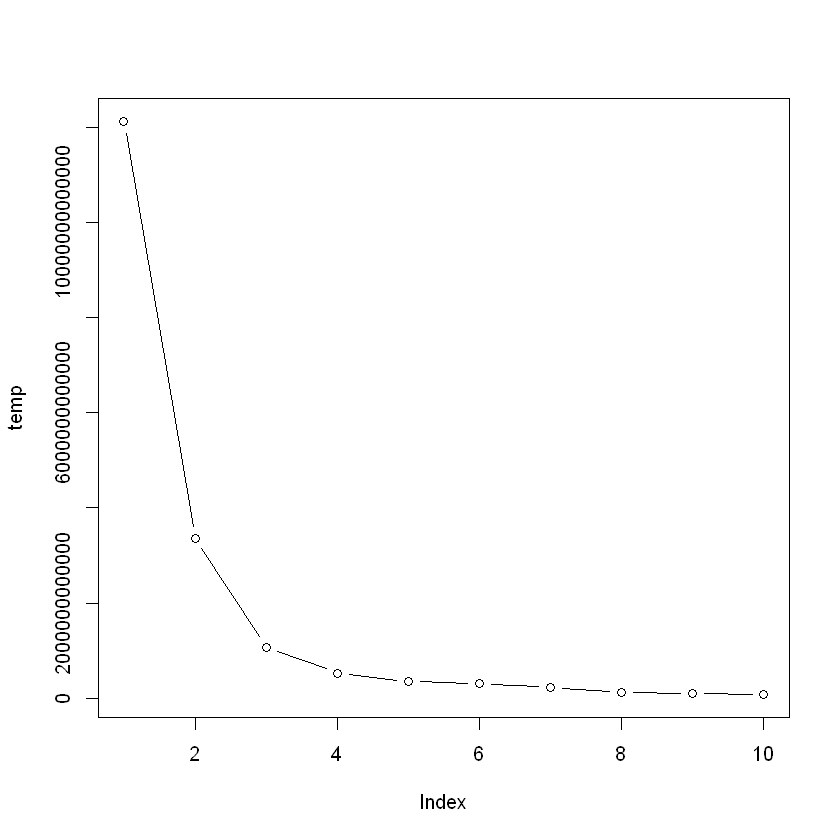

In [41]:
plot(temp, type="b")

In [51]:
a <- kmeans(set_two$누적관객수, centers = 3, iter.max = 100);a

K-means clustering with 3 clusters of sizes 17, 13, 7

Cluster means:
     [,1]
1 4749445
2 5464617
3 6192131

Clustering vector:
 [1] 1 2 1 2 1 1 1 1 2 2 2 1 1 3 1 3 1 1 3 2 1 3 2 1 3 2 2 3 2 3 1 2 1 2 2 1 1

Within cluster sum of squares by cluster:
[1] 656901125166 296153736375 122639286281
 (between_SS / total_SS =  91.1 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

In [52]:
set_two <- set_two[,-1]
set_two <- cbind(set_two, cluster=a$cluster)

In [53]:
set_two$cluster <- as.factor(set_two$cluster)

In [68]:
result <- rep(0,5)
temp <- rep(0,5)
n <- 55
for (i in 1:n) {
    samp <- createDataPartition(set_two$cluster, p = 0.7, list = F)

    # 학습용 데이터 셋
    data.tr <- subset(set_two[samp,], select = c(cluster, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 검증용 데이터셋
    data.test <- subset(set_two[-samp,], select = c(cluster, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 문제 및 정답 만들기
    x <- subset(data.test, select = -cluster)
    y <- data.test$cluster
    result[1] <- result[1] + f.nnet(data.tr, x, y)
    result[2] <- result[2] + f.ctree(data.tr, x, y)
    result[3] <- result[3] + f.randomForest(data.tr, x, y)
    result[4] <- result[4] + f.svm(data.tr, x, y)
    result[5] <- result[5] + f.multinom(data.tr, x, y)
    
    temp[1] <- temp[1] + f.nnet(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[2] <- temp[2] + f.ctree(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[3] <- temp[3] + f.randomForest(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[4] <- temp[4] + f.svm(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[5] <- temp[5] + f.multinom(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
}
result <- result / n
temp <- temp / n

# weights:  93
initial  value 42.450384 
iter  10 value 22.999838
iter  20 value 15.768181
iter  30 value 13.251371
iter  40 value 11.888185
iter  50 value 11.797501
iter  60 value 11.639887
iter  70 value 9.149193
iter  80 value 5.057500
iter  90 value 4.962553
iter 100 value 4.932332
final  value 4.932332 
stopped after 100 iterations
# weights:  21 (12 variable)
initial  value 29.662532 
iter  10 value 18.689804
iter  20 value 16.027244
iter  30 value 15.660751
iter  40 value 15.496185
iter  50 value 12.414390
iter  60 value 12.038409
iter  70 value 11.837072
iter  80 value 11.830955
iter  90 value 11.829787
iter 100 value 11.763351
final  value 11.763351 
stopped after 100 iterations
# weights:  93
initial  value 53.875512 
iter  10 value 22.990251
iter  20 value 13.605961
iter  30 value 11.254545
iter  40 value 8.849912
iter  50 value 7.734801
iter  60 value 6.632894
iter  70 value 6.231886
iter  80 value 5.830482
iter  90 value 5.694978
iter 100 value 5.648235
final  value 5.6482

initial  value 29.825107 
iter  10 value 19.067892
iter  20 value 15.284133
iter  30 value 8.853806
iter  40 value 5.388420
iter  50 value 3.160347
iter  60 value 1.959881
iter  70 value 1.910945
iter  80 value 1.910627
iter  90 value 1.910386
iter 100 value 1.909969
final  value 1.909969 
stopped after 100 iterations
# weights:  21 (12 variable)
initial  value 29.662532 
iter  10 value 17.997401
iter  20 value 12.427582
iter  30 value 11.998604
iter  40 value 11.828463
iter  50 value 11.364013
iter  60 value 11.359071
iter  70 value 11.358917
iter  80 value 11.357820
iter  90 value 11.357595
final  value 11.357593 
converged
# weights:  93
initial  value 50.642860 
iter  10 value 24.621858
iter  20 value 17.369715
iter  30 value 8.962890
iter  40 value 7.808592
iter  50 value 7.794536
iter  60 value 7.746890
iter  70 value 5.216644
iter  80 value 4.196339
iter  90 value 3.875841
iter 100 value 3.824966
final  value 3.824966 
stopped after 100 iterations
# weights:  21 (12 variable)
in

initial  value 29.662532 
iter  10 value 22.490330
iter  20 value 20.262018
final  value 20.252307 
converged
# weights:  93
initial  value 30.588144 
iter  10 value 24.121384
iter  20 value 20.785142
iter  30 value 18.782350
iter  40 value 14.941547
iter  50 value 14.829344
iter  60 value 12.127994
iter  70 value 11.049182
iter  80 value 10.573421
iter  90 value 9.752878
iter 100 value 9.733692
final  value 9.733692 
stopped after 100 iterations
# weights:  21 (12 variable)
initial  value 29.662532 
iter  10 value 22.490330
iter  20 value 20.262018
final  value 20.252307 
converged
# weights:  93
initial  value 36.330868 
iter  10 value 25.786452
iter  20 value 21.670846
iter  30 value 16.889957
iter  40 value 16.058092
iter  50 value 15.978409
iter  60 value 15.969157
iter  70 value 15.967927
iter  80 value 15.967761
final  value 15.967758 
converged
# weights:  21 (12 variable)
initial  value 29.662532 
iter  10 value 18.624656
iter  20 value 13.113554
iter  30 value 12.810023
iter 

initial  value 29.662532 
iter  10 value 17.454474
iter  20 value 13.111597
iter  30 value 12.918613
iter  40 value 12.912851
iter  50 value 12.911589
iter  60 value 12.911158
iter  70 value 12.910755
iter  80 value 12.910434
iter  90 value 12.910324
iter 100 value 12.909882
final  value 12.909882 
stopped after 100 iterations
# weights:  93
initial  value 30.146059 
iter  10 value 22.912710
iter  20 value 17.830157
iter  30 value 15.468668
iter  40 value 15.404898
iter  50 value 15.371482
iter  60 value 15.306793
iter  70 value 15.267327
iter  80 value 15.237465
iter  90 value 15.229237
iter 100 value 15.227826
final  value 15.227826 
stopped after 100 iterations
# weights:  21 (12 variable)
initial  value 29.662532 
iter  10 value 18.416066
iter  20 value 16.177473
iter  30 value 15.830845
iter  40 value 15.818578
iter  50 value 15.787694
final  value 15.787557 
converged
# weights:  93
initial  value 44.136314 
iter  10 value 28.096067
iter  20 value 27.836378
iter  30 value 24.1225

initial  value 30.156508 
iter  10 value 22.794153
iter  20 value 18.097507
iter  30 value 16.093204
iter  40 value 14.349619
iter  50 value 12.593519
iter  60 value 12.574976
final  value 12.574875 
converged
# weights:  21 (12 variable)
initial  value 29.662532 
iter  10 value 18.094622
iter  20 value 12.185700
iter  30 value 11.987127
iter  40 value 11.986026
iter  50 value 11.985203
iter  60 value 11.984966
iter  70 value 11.984921
final  value 11.984875 
converged
# weights:  93
initial  value 40.718541 
iter  10 value 23.709567
iter  20 value 17.508949
iter  30 value 9.189439
iter  40 value 8.022871
iter  50 value 8.018192
final  value 8.018186 
converged
# weights:  21 (12 variable)
initial  value 29.662532 
iter  10 value 18.094622
iter  20 value 12.185700
iter  30 value 11.987127
iter  40 value 11.986026
iter  50 value 11.985203
iter  60 value 11.984966
iter  70 value 11.984921
final  value 11.984875 
converged
# weights:  93
initial  value 30.592547 
iter  10 value 23.114637


initial  value 32.661401 
iter  10 value 21.675362
iter  20 value 21.327927
iter  30 value 21.327375
final  value 21.327374 
converged
# weights:  21 (12 variable)
initial  value 29.662532 
iter  10 value 15.763576
iter  20 value 5.333795
iter  30 value 4.757534
iter  40 value 4.731554
iter  50 value 4.724969
iter  60 value 4.724058
iter  70 value 4.721855
iter  80 value 4.720426
iter  90 value 4.719591
iter 100 value 4.719241
final  value 4.719241 
stopped after 100 iterations
# weights:  93
initial  value 29.936462 
iter  10 value 20.828988
iter  20 value 17.696769
iter  30 value 15.004357
iter  40 value 13.694544
iter  50 value 10.267287
iter  60 value 9.295534
iter  70 value 8.421514
iter  80 value 8.155046
iter  90 value 8.048256
iter 100 value 7.145222
final  value 7.145222 
stopped after 100 iterations
# weights:  21 (12 variable)
initial  value 29.662532 
iter  10 value 21.691772
iter  20 value 19.767230
iter  30 value 19.759004
iter  40 value 19.758991
final  value 19.758988 


initial  value 29.662532 
iter  10 value 21.935228
iter  20 value 19.478727
iter  30 value 19.461251
iter  40 value 19.461242
final  value 19.461235 
converged
# weights:  93
initial  value 63.642522 
iter  10 value 25.075772
iter  20 value 19.811337
iter  30 value 13.050699
iter  40 value 11.671637
iter  50 value 10.465897
iter  60 value 10.412751
iter  70 value 10.411156
iter  80 value 10.410914
iter  90 value 10.404221
iter 100 value 8.053477
final  value 8.053477 
stopped after 100 iterations
# weights:  21 (12 variable)
initial  value 29.662532 
iter  10 value 21.935228
iter  20 value 19.478727
iter  30 value 19.461251
iter  40 value 19.461242
final  value 19.461235 
converged
# weights:  93
initial  value 29.021373 
iter  10 value 20.186318
iter  20 value 14.087907
iter  30 value 13.893323
iter  40 value 12.849698
iter  50 value 11.851373
iter  60 value 11.507894
iter  70 value 11.080661
iter  80 value 10.763855
iter  90 value 10.740623
iter 100 value 10.731868
final  value 10.73

initial  value 29.662532 
iter  10 value 16.395544
iter  20 value 11.892422
iter  30 value 10.385357
iter  40 value 10.282551
iter  50 value 10.278970
iter  60 value 10.274086
iter  70 value 10.271350
iter  80 value 10.218897
iter  90 value 10.213352
iter 100 value 10.211983
final  value 10.211983 
stopped after 100 iterations
# weights:  93
initial  value 36.742072 
iter  10 value 19.731340
iter  20 value 10.890128
iter  30 value 10.468683
iter  40 value 9.520905
iter  50 value 9.465674
iter  60 value 9.463583
iter  70 value 9.462727
iter  80 value 9.462641
iter  90 value 9.462628
iter 100 value 9.462600
final  value 9.462600 
stopped after 100 iterations
# weights:  21 (12 variable)
initial  value 29.662532 
iter  10 value 19.092602
iter  20 value 13.381609
iter  30 value 12.404196
iter  40 value 12.306518
iter  50 value 12.262999
iter  60 value 12.238945
iter  70 value 12.231829
final  value 12.231746 
converged
# weights:  93
initial  value 28.628688 
iter  10 value 18.985283
iter 

In [69]:
res_all <- rbind(t(as.data.frame(temp)),
t(as.data.frame(result)))
colnames(res_all) <- c("인공신경망", "의사결정나무", "randomForest", "SVM", "다항로지스틱회귀분석")
rownames(res_all) <- c("트레이닝", "테스트")
res_all

,인공신경망,의사결정나무,randomForest,SVM,다항로지스틱회귀분석
트레이닝,0.8424242,0.5185185,1.0000000,0.8808081,0.7629630
테스트,0.4927273,0.5163636,0.5472727,0.5727273,0.5690909


In [56]:
temp <- c()
for ( i in 1:10) {
    a <- kmeans(set_three$누적관객수, centers = i, iter.max = 100)
    temp <- append(temp, a$tot.withinss)
}

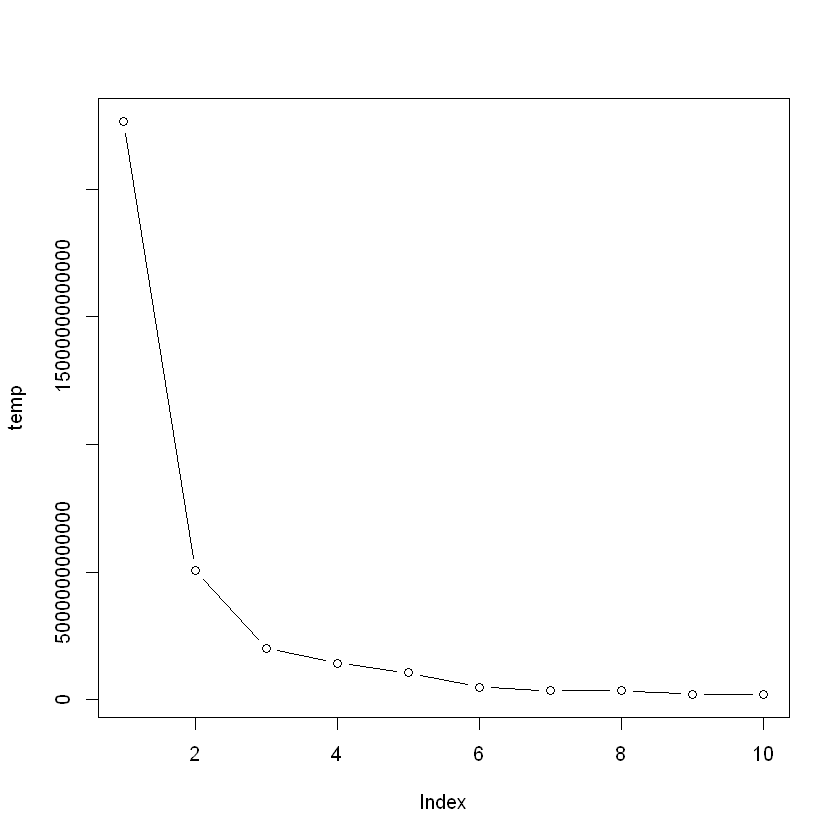

In [58]:
plot(temp, type="b")

In [62]:
a <- kmeans(set_three$누적관객수, centers = 3, iter.max = 100);a

K-means clustering with 3 clusters of sizes 15, 7, 6

Cluster means:
     [,1]
1 6975955
2 7808918
3 9157454

Clustering vector:
 [1] 1 3 1 2 2 3 2 1 1 1 2 1 1 2 1 1 3 3 1 3 1 1 1 2 1 3 1 2

Within cluster sum of squares by cluster:
[1] 685767482514 437124329500 902408282875
 (between_SS / total_SS =  91.1 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

In [63]:
set_three <- set_three[,-1]
set_three <- cbind(set_three, cluster=a$cluster)

In [64]:
set_three$cluster <- as.factor(set_three$cluster)

In [70]:
result <- rep(0,5)
temp <- rep(0,5)
n <- 55
for (i in 1:n) {
    samp <- createDataPartition(set_three$cluster, p = 0.7, list = F)

    # 학습용 데이터 셋
    data.tr <- subset(set_three[samp,], select = c(cluster, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 검증용 데이터셋
    data.test <- subset(set_three[-samp,], select = c(cluster, 배우점수, 감독_배우시너지, 스크린점유율, 감독점수, 장르_관객점수부여))

    # 문제 및 정답 만들기
    x <- subset(data.test, select = -cluster)
    y <- data.test$cluster
    result[1] <- result[1] + f.nnet(data.tr, x, y)
    result[2] <- result[2] + f.ctree(data.tr, x, y)
    result[3] <- result[3] + f.randomForest(data.tr, x, y)
    result[4] <- result[4] + f.svm(data.tr, x, y)
    result[5] <- result[5] + f.multinom(data.tr, x, y)
    
    temp[1] <- temp[1] + f.nnet(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[2] <- temp[2] + f.ctree(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[3] <- temp[3] + f.randomForest(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[4] <- temp[4] + f.svm(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
    temp[5] <- temp[5] + f.multinom(data.tr, subset(data.tr, select = -cluster), data.tr$cluster)
}
result <- result / n
temp <- temp / n

# weights:  93
initial  value 23.049483 
iter  10 value 21.463687
iter  20 value 21.054008
iter  30 value 15.352738
iter  40 value 14.857142
iter  50 value 14.856309
final  value 14.856308 
converged
# weights:  21 (12 variable)
initial  value 23.070858 
iter  10 value 14.654851
iter  20 value 11.681086
iter  30 value 11.609466
iter  40 value 11.581943
final  value 11.579931 
converged
# weights:  93
initial  value 38.363859 
iter  10 value 20.047059
iter  20 value 14.668324
iter  30 value 12.097694
iter  40 value 11.568947
iter  50 value 10.959916
iter  60 value 8.476364
iter  70 value 8.033185
iter  80 value 7.877578
iter  90 value 7.863804
iter 100 value 7.863769
final  value 7.863769 
stopped after 100 iterations
# weights:  21 (12 variable)
initial  value 23.070858 
iter  10 value 14.654851
iter  20 value 11.681086
iter  30 value 11.609466
iter  40 value 11.581943
final  value 11.579931 
converged
# weights:  93
initial  value 22.210215 
iter  10 value 19.168823
iter  20 value 13.

initial  value 24.685265 
iter  10 value 19.589616
iter  20 value 16.387141
iter  30 value 16.212344
iter  40 value 14.163417
iter  50 value 13.310606
iter  60 value 13.279325
iter  70 value 12.761405
iter  80 value 11.254399
iter  90 value 10.619065
iter 100 value 10.145728
final  value 10.145728 
stopped after 100 iterations
# weights:  21 (12 variable)
initial  value 23.070858 
iter  10 value 11.315511
iter  20 value 7.373436
iter  30 value 7.339543
iter  40 value 7.320322
iter  50 value 7.299121
iter  60 value 7.295939
iter  70 value 7.295482
iter  80 value 7.295377
iter  90 value 7.295324
iter 100 value 7.295288
final  value 7.295288 
stopped after 100 iterations
# weights:  93
initial  value 39.729956 
iter  10 value 21.463876
iter  20 value 21.463745
iter  20 value 21.463745
iter  20 value 21.463745
final  value 21.463745 
converged
# weights:  21 (12 variable)
initial  value 23.070858 
iter  10 value 13.477647
iter  20 value 10.298161
iter  30 value 10.239754
iter  40 value 10.

initial  value 23.070858 
iter  10 value 10.604519
iter  20 value 6.676481
iter  30 value 5.605502
iter  40 value 4.623904
iter  50 value 2.384461
iter  60 value 1.298374
iter  70 value 0.614037
iter  80 value 0.608863
iter  90 value 0.587654
iter 100 value 0.542334
final  value 0.542334 
stopped after 100 iterations
# weights:  93
initial  value 34.069253 
iter  10 value 21.463750
iter  20 value 21.461157
iter  30 value 20.520777
iter  40 value 16.434115
iter  50 value 14.988662
iter  60 value 14.502561
iter  70 value 14.108735
iter  80 value 13.305432
iter  90 value 13.302444
final  value 13.302440 
converged
# weights:  21 (12 variable)
initial  value 23.070858 
iter  10 value 13.724054
iter  20 value 11.239691
iter  30 value 10.973582
iter  40 value 10.849778
iter  50 value 10.773667
final  value 10.773654 
converged
# weights:  93
initial  value 35.631498 
iter  10 value 17.710600
iter  20 value 13.306657
iter  30 value 12.157298
iter  40 value 9.635069
iter  50 value 9.549532
ite

initial  value 23.070858 
iter  10 value 15.918668
iter  20 value 13.430297
iter  30 value 13.368542
iter  40 value 13.346270
final  value 13.341671 
converged
# weights:  93
initial  value 38.854178 
iter  10 value 15.990857
iter  20 value 10.730204
iter  30 value 6.846953
iter  40 value 5.875681
iter  50 value 4.268198
iter  60 value 4.204240
iter  70 value 4.169284
iter  80 value 4.161902
iter  90 value 4.158933
iter 100 value 4.158601
final  value 4.158601 
stopped after 100 iterations
# weights:  21 (12 variable)
initial  value 23.070858 
iter  10 value 13.778134
iter  20 value 10.088067
iter  30 value 9.349875
iter  40 value 9.041959
iter  50 value 6.850058
iter  60 value 4.185768
iter  70 value 3.766451
iter  80 value 3.766038
iter  90 value 3.765508
iter 100 value 3.553492
final  value 3.553492 
stopped after 100 iterations
# weights:  93
initial  value 23.162384 
iter  10 value 18.098636
iter  20 value 17.968927
iter  30 value 17.131057
iter  40 value 15.461785
iter  50 value 

initial  value 23.070858 
iter  10 value 12.430927
iter  20 value 6.501079
iter  30 value 6.258286
iter  40 value 6.244237
iter  50 value 6.213818
iter  60 value 6.211070
iter  70 value 6.198335
final  value 6.198238 
converged
# weights:  93
initial  value 26.703680 
iter  10 value 21.463754
iter  20 value 21.463673
iter  30 value 16.247644
iter  40 value 16.216494
iter  50 value 16.216360
iter  50 value 16.216360
iter  50 value 16.216360
final  value 16.216360 
converged
# weights:  21 (12 variable)
initial  value 23.070858 
iter  10 value 11.843004
iter  20 value 9.241067
iter  30 value 9.163118
iter  40 value 9.151417
iter  50 value 9.145027
final  value 9.145027 
converged
# weights:  93
initial  value 34.081161 
iter  10 value 17.002212
iter  20 value 11.726292
iter  30 value 11.564819
iter  40 value 11.461761
iter  50 value 11.373015
iter  60 value 11.170123
iter  70 value 10.644219
iter  80 value 7.898869
iter  90 value 6.177182
iter 100 value 6.145110
final  value 6.145110 
st

initial  value 30.425126 
iter  10 value 19.034204
iter  20 value 11.161799
iter  30 value 10.949610
iter  40 value 9.660448
iter  50 value 9.462749
iter  60 value 9.459673
final  value 9.459662 
converged
# weights:  21 (12 variable)
initial  value 23.070858 
iter  10 value 14.162283
iter  20 value 10.298694
iter  30 value 10.062519
iter  40 value 9.866262
iter  50 value 9.323335
iter  60 value 9.275588
iter  70 value 9.268603
iter  70 value 9.268603
iter  70 value 9.268603
final  value 9.268603 
converged
# weights:  93
initial  value 21.239964 
iter  10 value 13.073207
iter  20 value 12.338990
final  value 12.338218 
converged
# weights:  21 (12 variable)
initial  value 23.070858 
iter  10 value 14.162283
iter  20 value 10.298694
iter  30 value 10.062519
iter  40 value 9.866262
iter  50 value 9.323335
iter  60 value 9.275588
iter  70 value 9.268603
iter  70 value 9.268603
iter  70 value 9.268603
final  value 9.268603 
converged
# weights:  93
initial  value 34.812617 
iter  10 value

initial  value 30.434891 
iter  10 value 21.460598
iter  20 value 17.600152
iter  30 value 13.466750
iter  40 value 13.367141
iter  50 value 13.366689
iter  60 value 13.366265
iter  70 value 13.308520
iter  80 value 11.660734
iter  90 value 10.534935
iter 100 value 9.746998
final  value 9.746998 
stopped after 100 iterations
# weights:  21 (12 variable)
initial  value 23.070858 
iter  10 value 13.489975
iter  20 value 11.230759
iter  30 value 11.201244
iter  40 value 11.200561
iter  40 value 11.200561
iter  40 value 11.200561
final  value 11.200561 
converged
# weights:  93
initial  value 23.413040 
iter  10 value 14.244879
iter  20 value 7.186436
iter  30 value 2.564947
iter  40 value 1.914237
iter  50 value 1.909595
iter  60 value 1.909543
final  value 1.909543 
converged
# weights:  21 (12 variable)
initial  value 23.070858 
iter  10 value 13.721820
iter  20 value 10.968897
iter  30 value 10.859894
iter  40 value 10.859710
final  value 10.859689 
converged
# weights:  93
initial  va

initial  value 23.579515 
iter  10 value 13.519063
iter  20 value 9.876548
iter  30 value 2.805608
iter  40 value 1.942150
iter  50 value 1.909917
iter  60 value 1.909552
final  value 1.909543 
converged
# weights:  21 (12 variable)
initial  value 23.070858 
iter  10 value 12.415684
iter  20 value 6.730241
iter  30 value 6.388171
iter  40 value 6.273467
iter  50 value 5.550169
iter  60 value 5.501510
iter  70 value 5.267349
iter  80 value 4.552785
iter  90 value 4.457831
iter 100 value 4.154272
final  value 4.154272 
stopped after 100 iterations
# weights:  93
initial  value 37.982345 
iter  10 value 20.274187
iter  20 value 17.744020
iter  30 value 11.840975
iter  40 value 8.098019
iter  50 value 6.887465
iter  60 value 5.136500
iter  70 value 4.072153
iter  80 value 3.887494
iter  90 value 3.813915
iter 100 value 3.333740
final  value 3.333740 
stopped after 100 iterations
# weights:  21 (12 variable)
initial  value 23.070858 
iter  10 value 12.678819
iter  20 value 9.619661
iter  30

In [71]:
res_all <- rbind(t(as.data.frame(temp)),
t(as.data.frame(result)))
colnames(res_all) <- c("인공신경망", "의사결정나무", "randomForest", "SVM", "다항로지스틱회귀분석")
rownames(res_all) <- c("트레이닝", "테스트")
res_all

,인공신경망,의사결정나무,randomForest,SVM,다항로지스틱회귀분석
트레이닝,0.8017316,0.5324675,1.0000000,0.7870130,0.8692641
테스트,0.5012987,0.5688312,0.6337662,0.5194805,0.5480519
